In [10]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "high-vis"])

from ffnn_eia import load_data, segment_array, FFNN, PinballLoss
from sklearn.model_selection import train_test_split

from torchtransformers.preprocessing import *
from torchtransformers.regression import *
from torchtransformers.compose import *

# Load data

In [6]:
# Segmenting, splitting, and re-flattening the data should give us the same train/test/validate
# split that the context_tune.py script uses but formatted into hours for the baseline models.
X, y, context = load_data("ERCOT")
context = np.repeat(context, 24, axis=0)
X = np.hstack([X, context])
X = segment_array(X, 24)
y = segment_array(y, 24)

# Train/test/validation split that is 70/20/10
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.333, shuffle=True, random_state=42)

# Re-flatten the data
X_train = X_train.reshape(-1, X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[2])
X_validate = X_validate.reshape(-1, X_validate.shape[2])
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
y_validate = y_validate.reshape(-1)

# Load trained models

In [11]:
models = {}
for file in os.listdir("models"):
    if not file.endswith(".pk"):
        continue
    with open(f"models/{file}", "rb") as f:
        models[file.split(".")[0]] = pickle.load(f)

/Users/jacobbryan/miniforge3/envs/torch/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacobbryan/miniforge3/envs/torch/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Normalizer from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jacobbryan/miniforge3/envs/torch/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler 

# Evaluate and Plot

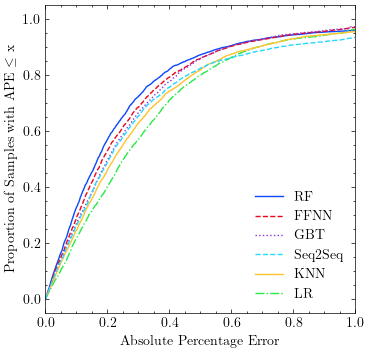

In [18]:
df_pred = pd.DataFrame({"True": y_validate})

plt.figure(figsize=(4, 4))
for model_name, model in models.items():
    if model_name == "ffnn":
        y_pred = model(torch.tensor(X_validate).float()).detach().numpy().ravel()
    else:
        y_pred = model.predict(X_validate)
    y_pred[y_pred > 5000] = 5000
    df_pred[model_name.upper()] = y_pred
    ape = np.abs((y_validate - y_pred) / y_validate)
    ape_ecdf = np.cumsum(np.ones_like(ape)) / len(ape)
    # plt.ecdf(ape, label=model_name.upper())
    plt.plot(np.sort(ape), ape_ecdf, label=model_name.upper())

df_s2s = pd.read_csv("seq2seq_validate_samples.csv")
y_val_s2s = df_s2s["True"]
y_pred_s2s = df_s2s["Predicted"]
ape = np.abs((y_val_s2s - y_pred_s2s) / y_val_s2s)
ape_ecdf = np.cumsum(np.ones_like(ape)) / len(ape)
# plt.ecdf(ape, label="Seq2Seq")
plt.plot(np.sort(ape), ape_ecdf, label="Seq2Seq")

df_pred["Seq2Seq"] = y_pred_s2s

# plt.legend()

# Reorder the legend entries to be ["RF", "FFNN", "GBT", "KNN", "LR"]
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index(model) for model in ["RF", "FFNN", "GBT", "Seq2Seq", "KNN", "LR"]]
plt.legend([handles[i] for i in order], ["RF", "FFNN", "GBT", "Seq2Seq", "KNN", "LR"], loc="lower right")

# plt.grid()
plt.xlim(0, 1)
plt.xlabel("Absolute Percentage Error")
plt.ylabel(r"Proportion of Samples with APE $\leq$ x")
plt.savefig("plots/regression_ape_cdf.png", dpi=300, bbox_inches="tight")
plt.show()

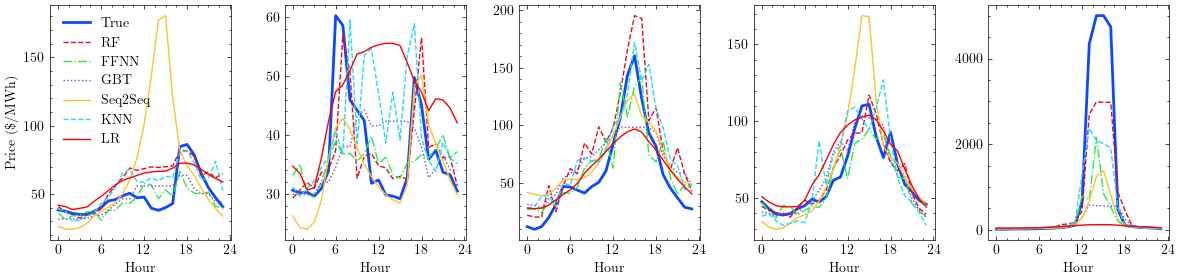

In [ ]:
n_plots = 5
fig, ax = plt.subplots(1, n_plots, figsize=(12, 3))
for k in ["True", "RF", "FFNN", "GBT", "Seq2Seq", "KNN", "LR"]:
    pred = df_pred[k].values
    samples = pred.reshape(-1, 24)
    for i in range(n_plots):
        ax[i].plot(samples[i], label=k, color="red" if k == "LR" else None, linewidth=2 if k == "True" else 1)
ax[0].legend()
ax[0].set_ylabel("Price (\$/MWh)")
for a in ax:
    a.set_xlabel("Hour")
    a.locator_params(axis="y", nbins=5)
    a.set_xticks([0, 6, 12, 18, 24])
plt.tight_layout()
plt.savefig("plots/regression_samples.png", dpi=300, bbox_inches="tight")
plt.show()